In [3]:
from platform import python_version

print(python_version())

3.7.5


In [4]:
# ############## AAS 237 MACHINE LEARNING WORKSHOP, JANUARY 2021 ###############
#
# TUTORIAL 1d: SOM Classification
#
# GOAL: The goal of this tutorial is to learn how (unsupervised) Self-Organizing maps (SOM)
# can be used to visualize datasets. A nice expanation of the SOM with history can be found
# here: https://towardsdatascience.com/kohonen-self-organizing-maps-a29040d688da
# 
#
# DATA: We use the same dataset as in the previous tutorial 1a. These are Hubble H-band images from
# the CANDELS survey on the GOODS-S field. We provide ~3000 image cutouts of galaxies at low redshifts,
# which have been classified visually by Kartaltepe et al. (2015, https://ui.adsabs.harvard.edu/abs/2015ApJS..221...11K/abstract)
# in spheroidal and disk morphology.
# 
# 
# OUTLINE: We use the (unsupervised) SOM algorithm to group the Hubble H-band images of ~3000 galaxies.
# The algorithm is unsupervised, therefore it will group the galaxies without a training sample and project them
# onto a 2-dimensional space. We will subsequently map the galaxies back into this parameter space to understand
# the grouping performed by the SOM algorithm and we will find a good separation between spheroids and disks.
#
#
# CONTACT: Andreas Faisst (afaisst@ipac.caltech.edu)
#
#
# ####################################################

In [3]:
# ========================== 1. LOAD PACKAGES ==========================
# We first load all the packages that are needed in this tutorial.
#

## a) general packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import time
import random
from astropy.table import Table

## b) Load SOM
# for the SOM (http://www.pymvpa.org/index.html)
# specifically how to use the SOM: http://www.pymvpa.org/examples/som.html
# https://github.com/PyMVPA/PyMVPA
# to install it, use "pip install pymvpa2"
from mvpa2.mappers.som import SimpleSOMMapper

## c) Set up plotting parameters
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['hatch.linewidth'] = 1.5
def_cols = plt.rcParams['axes.prop_cycle'].by_key()['color']


/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/duecredit/utils.py:32: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/duecredit/utils.py:33: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[1].startswith('7.')
/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/duecredit/io.py:18: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import defaultdict, Iterator


In [4]:
# ========================== 2. DEFINE SOME FUNCTIONS ==========================
# Let's define some useful functions here

## Create map containing the percentage of disk galaxies per SOM cell
# input: som dimensions and som_results (containing X, Y, label)
def som_fractionmap(mapsize , som_results):
    
    mat = np.zeros(mapsize)
    for xx in range(mapsize[0]):
        for yy in range(mapsize[1]):
            objects_in_cell = np.where( (som_results["Y"] == xx) & (som_results["X"] == yy) )[0]
            if len(objects_in_cell) == 0:
                mat[yy,xx] = np.nan
            else:
                mat[yy,xx] = len(np.where(som_results["label"][objects_in_cell] == 1)[0]) / len(objects_in_cell)

    out = {"map":mat}
    return(out)

## Create hit map containing the number of objects per SOM cell
# input: som dimensions and som_results (containing X, Y, label)
def som_hitmap(mapsize , som_results):
    
    mat = np.zeros(mapsize)
    for xx in range(mapsize[0]):
        for yy in range(mapsize[1]):
            objects_in_cell = np.where( (som_results["Y"] == xx) & (som_results["X"] == yy) )[0]
            if len(objects_in_cell) > 0:
                mat[yy,xx] = len(objects_in_cell)
            else:
                mat[yy,xx] = np.nan

    out = {"map":mat}
    return(out)

## Create median map for a specific property (median per cell)
# input: som dimensions, som_results (containing X, Y, label), and key (in som_results, e.g., "lssfr")
def som_medianmap(mapsize , som_results, key):
    
    mat = np.zeros(mapsize)
    for xx in range(mapsize[0]):
        for yy in range(mapsize[1]):
            objects_in_cell = np.where( (som_results["Y"] == xx) & (som_results["X"] == yy) )[0]
            if len(objects_in_cell) > 0:
                mat[yy,xx] = np.nanmedian(som_results[key][objects_in_cell])
            else:
                mat[yy,xx] = np.nan

    out = {"map":mat}
    return(out)


## This function is to rebin the images (median rebinning)
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)


## This function returns some metrics to measure how good the predictions are
# tab: input table
# true_limit: limit for binary definition (e.g., 0.5: 0.5 -> 0 (false) and 0.51 -> 1 (true) )
# key_true: column in table for true value
# key_pred: column in table for predicted values
# confusion matrix is defined ad
#   TN   FP
#   FN   TP
def get_metrics(tab,true_limit, key_true , key_pred):

    TN = len(np.where( (tab[key_true] == 0) & (tab[key_pred]<=true_limit) )[0] )
    FP = len(np.where( (tab[key_true] == 0) & (tab[key_pred]>true_limit) )[0] )
    FN = len(np.where( (tab[key_true] == 1) & (tab[key_pred]<=true_limit) )[0] )
    TP = len(np.where( (tab[key_true] == 1) & (tab[key_pred]>true_limit) )[0] )
    TOP = len(tab)
    
    #Matthew's correlation coefficient (MCC)
    MCC = ( (TP*TN) - (FP*FN) ) / np.sqrt( (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN) )
    
    # standard measures
    ACC = (TN+TP)/TOP
    conf_matrix = np.asarray([TN,FP,FN,TP]).reshape((2,2))/TOP
    precision = TP/(TP+FP) # this is identical to the purity
    recall = TP/(TP+FN) # this is identical to the completeness
    balancedACC = 0.5*( (TP/(TP+FN)) + (TN/(TN+FP)) )
    f1measure = 2.0 * (precision*recall) / (precision + recall)
    
    out = {"MCC":MCC,
           "ACC":ACC,
           "conf_matrix":conf_matrix,
          "precision":precision,
          "recall":recall,
          "balancedACC":balancedACC,
          "f1measure":f1measure}
    
    return(out)




In [5]:
# ========================== 3. LOAD FILES ==========================
# Now, we load all the files (images, labels, info). The data match line by line.
# The dataset that we are going to use is in the form of pickle files.
# For more information on using pickle files, see https://docs.python.org/3/library/pickle.html 

## a) Load F160W images
## This will load a 3-dimensional array where the first dimension is the number of cutouts
## and the second and third dimensions are the dimensions of the cutout themselves (41x41 pixels)
with open("../data/f160w_images_unique.pickle","rb") as f:
    f160w_images = pickle.load(f)

    
## b) Load F160W labels
## This will load a 2-dimensional array and contains one label (1=disk, 0=spheroid) for each cutout
with open("../data/f160w_labels_unique.pickle","rb") as f:
    f160w_labels = pickle.load(f)
    

## c) Load F160W info
## This will load a 2-dimensional array containing additional info for each galaxy (such as RA/DEC coordiantes)
with open("../data/f160w_data_info_unique.pickle","rb") as f:
    f160w_info = pickle.load(f)


## d) Let's print some things for information
print("Shape of image array: ", f160w_images.shape)
print("Shape of label array: " , f160w_labels.shape)
print("Number of Spheriod: %g" % len(np.where(f160w_labels == 0)[0]) )
print("Number of Disks: %g" % len(np.where(f160w_labels == 1)[0]) )

Shape of image array:  (2120, 41, 41)
Shape of label array:  (2120,)
Number of Spheriod: 427
Number of Disks: 1693


In [6]:
# ========================== 4. CREATE FLATTENED IMAGES SO SOM ALGORITHM CAN READ THEM ==========================
# As t-SNE, the SOM algorithm needs a 2-dimensional array where the objects to classify are the rows and
# the different estimator are the columns. This is different compare to the convolutional networks
# that work in n-dimensions. Since we are dealing here with 41x41 pixel images, we have have
# to flatten them into a 41*41 array and store them in a 2d array.

## a) How many cutouts to load?
## For testing, you could load less to make it faster.
n_load = f160w_images.shape[0]
#n_load = 100

## b) new dimenions after rebinning
## The SOM is much slower than t-SNE. Therefore we rebin here the images from 41 x 41 pixels to 10 x 10 pixels.
## Because 41 is a prime number, we remove 1 pixels on each side to make it 40 x 40 pixels and then bin by a factor of 4.
dim_rebin = (10,10)

## b) create an 2-dimensional array with the flattened cutouts
f160w_images_som = np.zeros((n_load, dim_rebin[0]*dim_rebin[1] ) )
nan_counter = 0
for ii in range(n_load):
    tmp = rebin(f160w_images[ii][1:,1:],dim_rebin)
    f160w_images_som[ii,:] = tmp.flatten() #f160w_images[ii].flatten()



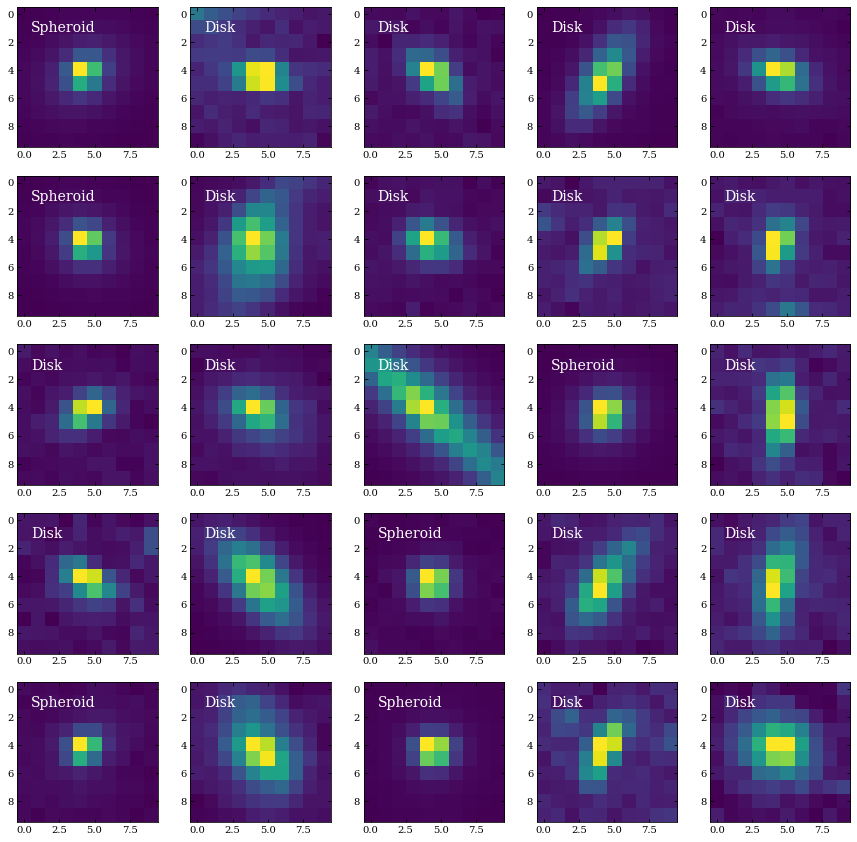

In [7]:
# ========================== 5. PLOT SOME GALAXIES ==========================
# Let's plot some of the galaxies with the corresponding labels.
# Remember that the labels are defined as 1=Disk and 0=Spheroid.
# Below, we load the first 25 cutouts.


fig = plt.figure(figsize=(15,15))

for ii in range(25):
    ax = fig.add_subplot(5,5,ii+1)
    gal_number = ii
    ax.imshow(f160w_images_som[gal_number].reshape(dim_rebin))
    ax.text(0.1,0.9,["Spheroid","Disk"][f160w_labels[gal_number]],color="white",fontsize=14,va="top",ha="left",transform=ax.transAxes)
    
#plt.savefig("tutorial1d_fig1.pdf",bbox_inches="tight")
plt.show()

In [8]:
# ========================== 5. RUN SOM ALGORITHM AND MAKE NICE OUTPUT TABLE ==========================
# We now can run the SOM algorithm on the flattened image arrays.

## a) Dimension of SOM
# This is the number of pixels in each direction in 2-dimensional SOM space.
som_dim = [20,20]


## b) set the seed so the map always looks the same
# The SOM is initiated randomly. Fix here the random seed to generate the same map for each run.
random.seed(3)

## c) Create a SOM model
# Let's create a SOM model. Input are number of dimensions, number of iterations and lerning_rate.
# There are more parameters (such as the Initial radius of the Gaussian neighborhood kernel). You can play around with those
# but the default parameters are already good enough.
#som = mvpa2.mappers.som.SimpleSOMMapper((som_dim[0], som_dim[1]), niter=200, learning_rate=0.05)
som = SimpleSOMMapper((som_dim[0], som_dim[1]), niter=200, learning_rate=0.05)

## c) "Train" the SOM
# Here we "train" the SOM. Note that we do not input labels as the SOM algorithm is an unsupervised
# machine learning method. So, we rather "fit" the SOM. We also output the time. On a typical
# Macbook Pro, this runs in 2-3 minutes. Note that this is about 4 times slower than the t-SNE that we ran before.
print("Training SOM . . . " , end="")
start_time = time.time() ## GET TIME
som.train( f160w_images_som )
elapsed_time = round( (time.time() - start_time)/60,2)
print("SOM trained in %s minutes!!" % (elapsed_time))
print("SOM dimensions: " + str(som.K.shape))



Training SOM . . . SOM trained in 3.91 minutes!!
SOM dimensions: (20, 20, 100)


In [9]:
# ========================== 6. MAP OBJECTS TO SOM ==========================
# Now, as we have "trained" the SOM, we can map objects onto the SOM. This allows us, similar to the t-SNE
# to check the output and understand how the SOM arranged the different galaxies in its cells.
# Note the big difference to t-SNE: the SOM groups galaxies in cells (in this example 20x20=400 cells) and
# does not provide a continuous distribution.

## a) Map our galaxies to the SOM
# Note that we can assume that all galaxies are our "test" sample because the method is unsupervised and does
# not require a "training" sample. We also output the time, but this step should be instantaneous.
# The resulting objects ("mapped") contains, for each galaxy, the X and Y coordinates of the SOM cells.
print("Mapping Objects onto SOM . . .")
start_time = time.time() ## GET TIME
mapped = som(np.asarray(f160w_images_som))
elapsed_time = round( (time.time() - start_time)/60,2)
print("Objects mapped onto SOM in %s minutes!!" % (elapsed_time))

## b) Create a nice table
# As for the t-SNE, let's gather our results and create a table.
som_results = Table(names=["id","label","X","Y"],dtype=["int","int","f","f"])
for ii in range(mapped.shape[0]):
    som_results.add_row([ii, f160w_labels[ii], mapped[ii][0], mapped[ii][1] ])
    
## c) Create "fraction map": 1=disks, 0=spheroids
# Finally, we create a map that indicates the fraction of disk galaxies for each SOM cell.
# We use for this the function that we defined above, which very simply counts the number of disk galaxies
# in each of the 400 SOM cells and creates a matrix (="image") with the fraction of disk galaxies per cell.
# You can review this function or just take it as a given.
fractionmap = som_fractionmap(mapsize = som_dim , som_results=som_results)

## d) Create a "hit map" that shows the number of objects per cell.
# This is useful to evaluate of the size of the SOM is chosen correctly.
hitmap = som_hitmap(mapsize = som_dim , som_results=som_results)


## e) Compute accuracy
# For the SOM, this is easier because it has a nice mapping function

# Create test sample (just take first 500 which is roughly 25%)
test_sample = f160w_images_som[0:500]
test_labels = som_results[0:500]

# Map to SOM. This give the cells to which each of the galaxies belong to in the trained SOM
mapped_test = som(np.asarray(test_sample))

# Extract the labels for each of the galaxies.
# Since we know the average label per cell (computed in the fractionmap), we can compute the label for 
# each of the test galaxies that were mapped in the different cells in the previous step.
som_results_test = Table(names=["id","label","true_label","X","Y"],dtype=["int","int","int","f","f"])
for ii in range(mapped_test.shape[0]):
    true_label = test_labels[ii]["label"] # true label
    som_label = fractionmap["map"][mapped_test[ii][0],mapped_test[ii][1]] # label predicted by SOM
    som_results_test.add_row([test_labels["id"][ii], som_label , true_label, mapped_test[ii][0], mapped_test[ii][1] ])

# Now compute accuracy    
metrics = get_metrics(tab=som_results_test,
                      true_limit=0.5,
                      key_true="true_label", # column name of true labels
                      key_pred="label" # column name of predicted labels
                     )
print("-> Accuracy: %s" % metrics["ACC"])

Mapping Objects onto SOM . . .
Objects mapped onto SOM in 0.01 minutes!!
-> Accuracy: 0.862


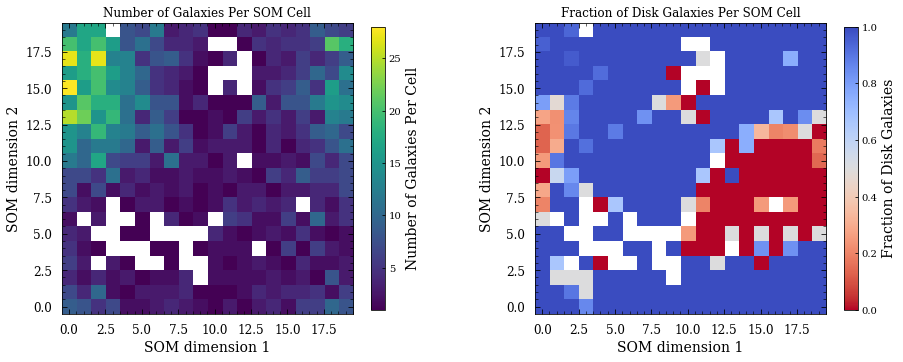

In [10]:
# ========================== 7. PLOT THE SOM MAP WITH FRACTION OF DISK GALAXIES ==========================
# Now, we can plot our "disk fraction map" that shows the fraction of disk galaxies per cell as well as 
# our "hit map" that shows the number of galaxies per SOM cell. This gives us an idea what the SOM does.
# You will see that the SOM can efficiently separate the spheriod (red) from disk (blue) galaxies. Note
# that the SOM can have holes (the white area).
# The size of the SOM defines ultimately the number of objects per cell. So, if the size is too large,
# more cells are empty. If the size is too small, the separation of objects is too coarse. As you see below,
# a map of the size 20 x 20 pixels provides a good balance.

# The SOM has the advantage that, using the model generate above, it is easy to map other galaxies to the SOM.
# For this, just use the "som()" function. This is an advantage over the t-SNE algorithm, for which this is
# not straight forward. In that case, the "test" sample has to be run with the "training" sample, which is use
# do define the regions on the t-SME map. Or the "test" sample can be matched to the training sample using a
# chi2 method.


# create figure
fig = plt.figure(figsize=(15,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.0)

## plot hit map on the left
ax1 = fig.add_subplot(1,2,1)

# plot our "disk fraction map" ## NOTE: should be "hit map"
im1 = ax1.imshow(hitmap["map"],origin="lower",cmap=plt.get_cmap("viridis"))

# define a color bar
cbar1 = fig.colorbar(im1,shrink=0.65)
cbar1.set_label("Number of Galaxies Per Cell",fontsize=14)

# define the axes
ax1.set_title("Number of Galaxies Per SOM Cell")
ax1.set_xlabel("SOM dimension 1" , fontsize=14)
ax1.set_ylabel("SOM dimension 2",fontsize=14)
ax1.set_xlim(0-0.5,som_dim[0]-0.5)
ax1.set_ylim(0-0.5,som_dim[1]-0.5)
ax1.tick_params(axis='both', which='major',length=5, labelsize=12,pad=10)
ax1.tick_params(axis='both',which='minor',length=3)
ax1.minorticks_on()



## plot fraction map on the right
ax2 = fig.add_subplot(1,2,2)

# plot our "disk fraction map"
im2 = ax2.imshow(fractionmap["map"],origin="lower",cmap=plt.get_cmap("coolwarm_r"))

# define a color bar
cbar2 = fig.colorbar(im2,shrink=0.65)
cbar2.set_label("Fraction of Disk Galaxies",fontsize=14)

# define the axes
ax2.set_title("Fraction of Disk Galaxies Per SOM Cell")
ax2.set_xlabel("SOM dimension 1" , fontsize=14)
ax2.set_ylabel("SOM dimension 2",fontsize=14)
ax2.set_xlim(0-0.5,som_dim[0]-0.5)
ax2.set_ylim(0-0.5,som_dim[1]-0.5)
ax2.tick_params(axis='both', which='major',length=5, labelsize=12,pad=10)
ax2.tick_params(axis='both',which='minor',length=3)
ax2.minorticks_on()


#plt.savefig("tutorial1d_fig2.pdf",bbox_inches="tight")
plt.show()





/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


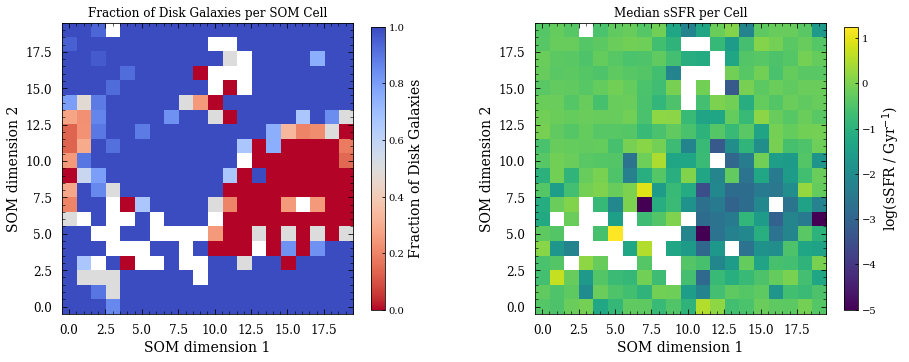

In [11]:
# ========================== 8. PAINT PHYSICAL PROPERTIES ON SOM MAP ==========================
# Another thing to look at is the specific star-formation rate (sSFR) of galaxies. The sSFR is related to the
# growth of a galaxy or the rate of star formation per unit mass (sSFR = SFR / M).
# Here, we use the additional info for our galaxies (specifically their RA/DEC coordinates) to match
# them to the 3D-HST catalog (Skelton et al. 2014; Brammer et al. 2015; Momcheva et al. 2015), which contains SED fits
# to all the galaxies in the GOODS-S CANDELS field.
# For more information on 3D-HST, see the data page: https://3dhst.research.yale.edu/Data.php

## a) Load the 3D-HST catalog
sedfits = Table.read("../data/goodss_3dhst_v4.1_merged.fits")

## b) Match our galaxies to the 3D-HST catalog by using their RA and DEC coordinates
## We use here a very simple matching and take the closest galaxy withing a radius of 2 arcseconds.
## This may not be ideal and you can use a more sophisticated matching for example using
## the tools from ASTROPY/SKYCOORD (https://docs.astropy.org/en/stable/coordinates/matchsep.html)
## In the following, we add the sSFR measurements (in 1/Gyr) to the "tsne_results" table for easy access.
som_results["lssfr"] = np.zeros(len(som_results))
for ii in range(f160w_info.shape[0]):
    d = 3600*np.sqrt( ( sedfits["ra"] - f160w_info[ii][1] )**2 + ( sedfits["dec"] - f160w_info[ii][2] )**2 ) # distance in arcseconds
    
    if np.nanmin(d) < 2: # closest within 2 arcseconds
        sel = np.where(d == np.nanmin(d))[0][0]
        som_results["lssfr"][ii] = sedfits["lssfr"][sel] + 9 # in 1/Gyr
    else:
        print("galaxy not found!")
        som_results["lssfr"][ii] = -99

sel_bad = np.where(som_results["lssfr"] <= -50)[0]
som_results["lssfr"][sel_bad] = np.nan


## c) Create "median map" to get median sSFR per SOM cell
# Similar to the t-SNE tutorial 1b, we can then study the distribution of sSFR as a function of morphology.
lssfr_medianmap = som_medianmap(mapsize = som_dim , som_results=som_results, key="lssfr")


## d) Plot the "median map" together with the "disk fraction map"
# This allows us to compare the two maps and we will see that disk galaxies have on average a higher
# specific SFR as spheroid galaxies (which is not unexpected)

# create figure
fig = plt.figure(figsize=(15,8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.0)

## plot fraction map on the left
ax1 = fig.add_subplot(1,2,1)

# plot our "disk fraction map"
im1 = ax1.imshow(fractionmap["map"],origin="lower",cmap=plt.get_cmap("coolwarm_r"))

# define a color bar
cbar1 = fig.colorbar(im1,shrink=0.65)
cbar1.set_label("Fraction of Disk Galaxies",fontsize=14)

# define the axes
ax1.set_title("Fraction of Disk Galaxies per SOM Cell")
ax1.set_xlabel("SOM dimension 1" , fontsize=14)
ax1.set_ylabel("SOM dimension 2",fontsize=14)
ax1.set_xlim(0-0.5,som_dim[0]-0.5)
ax1.set_ylim(0-0.5,som_dim[1]-0.5)
ax1.tick_params(axis='both', which='major',length=5, labelsize=12,pad=10)
ax1.tick_params(axis='both',which='minor',length=3)
ax1.minorticks_on()


## plot median map on the left
ax2 = fig.add_subplot(1,2,2)

# plot our median sSFR map
im2 = ax2.imshow(lssfr_medianmap["map"],origin="lower",cmap=plt.get_cmap("viridis") , vmin=-5)

# define a color bar
cbar2 = fig.colorbar(im2,shrink=0.65)
cbar2.set_label(r'log(sSFR / Gyr$^{-1}$)',fontsize=14)

# define the axes
ax2.set_title("Median sSFR per Cell")
ax2.set_xlabel("SOM dimension 1" , fontsize=14)
ax2.set_ylabel("SOM dimension 2",fontsize=14)
ax2.set_xlim(0-0.5,som_dim[0]-0.5)
ax2.set_ylim(0-0.5,som_dim[1]-0.5)
ax2.tick_params(axis='both', which='major',length=5, labelsize=12,pad=10)
ax2.tick_params(axis='both',which='minor',length=3)
ax2.minorticks_on()


#plt.savefig("tutorial1d_fig3.pdf",bbox_inches="tight")
plt.show()

